The aim of this project is to take the data in https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us?select=fulltimeCHI.csv about data scientist hire in 2018 in the US and "kind-of" replicate the analysis from the uploader published in https://nycdatascience.com/blog/student-works/who-gets-hired-an-outlook-of-the-u-s-data-scientist-job-market-in-2018/

Lert's start by loading the necessary packages for R

In [10]:
library(tidyverse)
library(data.table)
library(tm)
library(slam)

As second step, let's import the data using fread, and then let's check a bit the structure of the data.

In [2]:
job_descriptions <- fread('alldata.csv')
str(job_descriptions)

Classes ‘data.table’ and 'data.frame':	6964 obs. of  5 variables:
 $ position   : chr  "Development Director" "An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist" "Data Scientist" "Data Analyst" ...
 $ company    : chr  "ALS TDI" "The Hexagon Lavish" "Xpert Staffing" "Operation HOPE" ...
 $ description: chr  "Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Rep"| __truncated__ "Job Description\n\n\"\"The road that leads to accomplishment is narrow.\"\" -Desmond\nOstentatious is a strong "| __truncated__ "Growing company located in the Atlanta, GA area is currently looking to add a Data Scientist to their team. The"| __truncated__ "DEPARTMENT: Program OperationsPOSITION LOCATIONS: Atlanta, GA.ACCOUNTABILITY:  President of Program OperationsF"| __truncated__ ...
 $ reviews    : int  NA NA NA 44 550 385 385 899 3343 4494 ...
 $ location   : chr  "Atlanta, GA 30301 " "Atlanta, GA" "Atlanta, GA" "Atlanta, GA

This crude inspection reveals one feature that it's for me easier to manage: <br>
1. the same city appears with different names because postal codes are sometimes included <br>
2. States appear within the location and not as a separate column. <br>

To solve this issue, I first split the string a few times to isolate City and State information, and throw away postal codes.

In [3]:
job_descriptions <- job_descriptions %>%
    separate(location, c('city', 'state'), ', ', fill = "left") %>%
    separate(state, c('state'), ' ', extra = 'drop') #%>%
    #mutate(city = as.factor(city), state = as.factor(state))

str(job_descriptions)
table(job_descriptions$position)

Classes ‘data.table’ and 'data.frame':	6964 obs. of  6 variables:
 $ position   : chr  "Development Director" "An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist" "Data Scientist" "Data Analyst" ...
 $ company    : chr  "ALS TDI" "The Hexagon Lavish" "Xpert Staffing" "Operation HOPE" ...
 $ description: chr  "Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Rep"| __truncated__ "Job Description\n\n\"\"The road that leads to accomplishment is narrow.\"\" -Desmond\nOstentatious is a strong "| __truncated__ "Growing company located in the Atlanta, GA area is currently looking to add a Data Scientist to their team. The"| __truncated__ "DEPARTMENT: Program OperationsPOSITION LOCATIONS: Atlanta, GA.ACCOUNTABILITY:  President of Program OperationsF"| __truncated__ ...
 $ reviews    : int  NA NA NA 44 550 385 385 899 3343 4494 ...
 $ city       : chr  "Atlanta" "Atlanta" "Atlanta" "Atlanta" ...
 $ state      : c


                                                                                                                                                                                 
                                                                                                                                                                              11 
                                                                                                                                                       .NET/SharePoint Developer 
                                                                                                                                                                               1 
                                                                                                                                        (Contract) Business Intelligence Analyst 
                                                                                                             

A second feature that is immediately clear from the structure of the dataframe with explicit locations is that the job titles are pretty heterogeneous. To get a better sense of what it's in there, I will attempt use the tm package to count the frequency of ngrams made by 1 or 2 words. Such choice is justified because common positions for data-related jobs are combination of two words (e.g. "data science", "data engineer", "data analyst", "machine learning") 

<<TermDocumentMatrix (terms: 62, documents: 6964)>>
Non-/sparse entries: 20064/411704
Sparsity           : 95%
Maximal term length: 20
Weighting          : term frequency (tf)

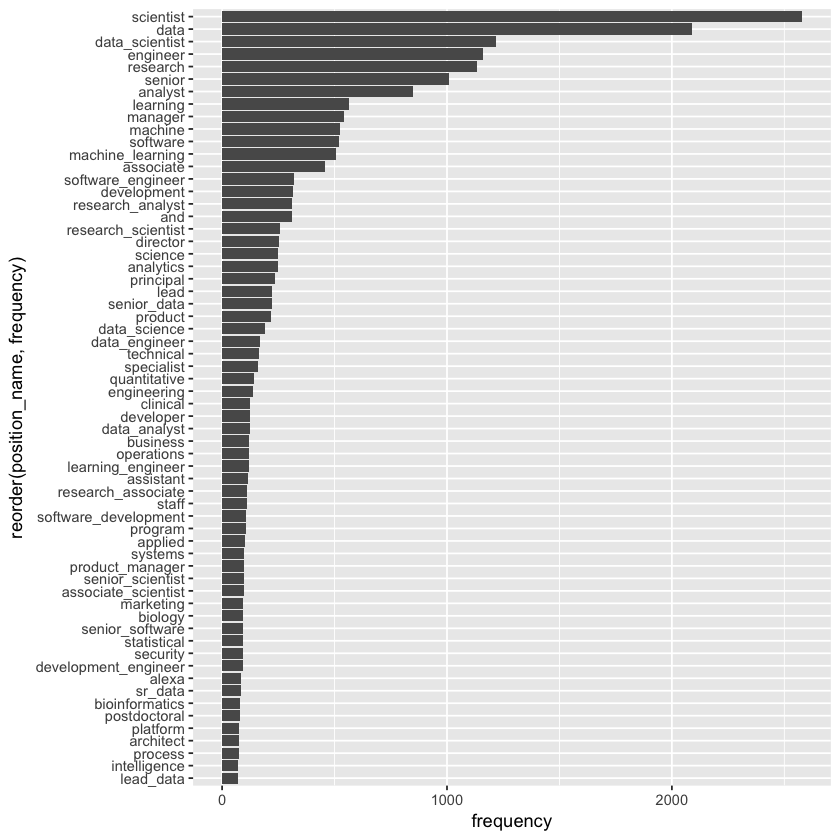

In [16]:
# create corpus from the position descriptions
corpus_positions <- job_descriptions$position
corpus_positions <- tolower(corpus_positions)
corpus_positions <- removeNumbers(corpus_positions)
corpus_positions <- removePunctuation(corpus_positions)

corpus_positions <- VCorpus(VectorSource(corpus_positions))

# create function that computes ngrams of 1 and 2 words
NLP_tokenizer <- function(x) {
  unlist(lapply(ngrams(words(x), 1:2), paste, collapse = "_"), use.names = FALSE)
}

# create term-document-matrix for positions and create dataframe with frequencies of bigrams
TDM_positions <- TermDocumentMatrix(corpus_positions, control = list(tokenize = NLP_tokenizer))
TDM_positions <- removeSparseTerms(TDM_positions, 0.99)
TDM_positions                          
                                    
# estracting aggregate information
frequency_of_position_names <- data.frame(frequency = row_sums(as.matrix(TDM_positions)))
frequency_of_position_names <- rownames_to_column(frequency_of_position_names, "position_name") %>%
    arrange(desc(frequency))

frequency_of_position_names %>%
    ggplot(aes(x = reorder(position_name, frequency), y = frequency)) +
    geom_col() + 
    coord_flip()

From this manipulation I can already obtain a first useful information, the cities and States that have most job openings according to this database. This information does not include any detail about the job type, but it's a starting point.

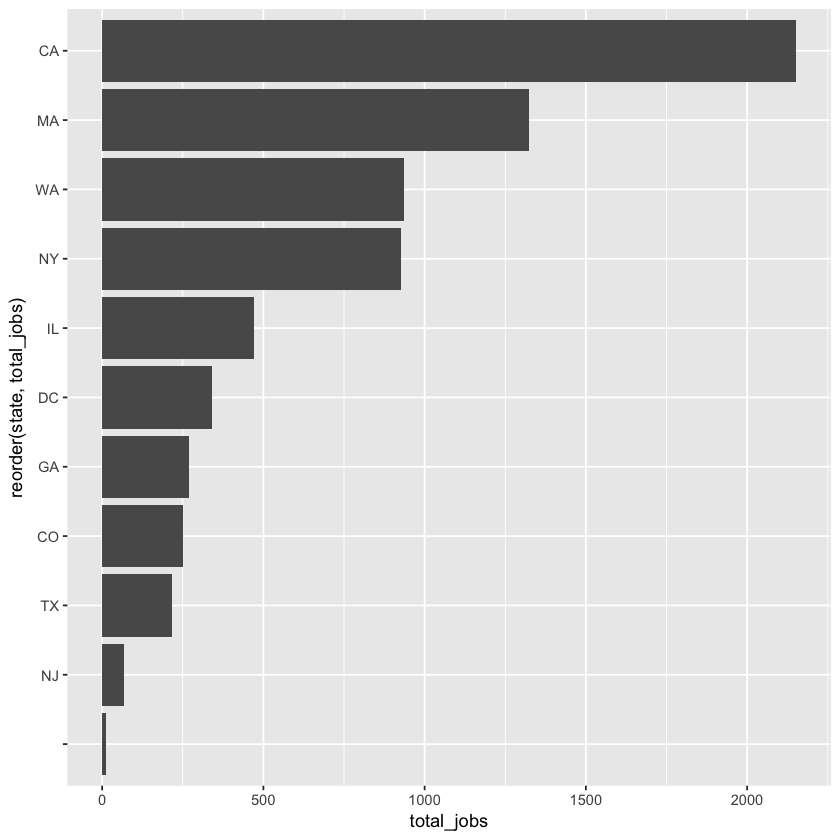

In [5]:
# construction of summary containing the total jobs for each state
summary_total_job_locations_by_states <- job_descriptions %>%
    select(state, city) %>%
    group_by(state) %>%
    summarize(total_jobs = n()) %>%
    ungroup() %>%
    arrange(desc(total_jobs))

summary_total_job_locations_by_states %>%
    ggplot(aes(x = reorder(state, total_jobs), y = total_jobs)) +
    geom_col() +
    coord_flip()

In [8]:
tdm

<<TermDocumentMatrix (terms: 2671, documents: 6964)>>
Non-/sparse entries: 26610/18574234
Sparsity           : 100%
Maximal term length: 54
Weighting          : term frequency (tf)